# Data Cleaning 

In [1]:
using Pkg;

# Installing packages
#Pkg.add("DelimitedFiles")
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("Pandas")
#Pkg.add("CategoricalArrays")
#Pkg.add("DataFramesMeta")
#Pkg.add("ScikitLearn")
#Pkg.add("GLM")
#Pkg.add("Plots")

In [2]:
using DelimitedFiles
using CSV
using Statistics 
using DataFramesMeta #using DataFrames
using CategoricalArrays;
include("./utils/preprocessing_utils.jl")
using GLM
using Plots

In [3]:
data = CSV.File("./dataset/music_genre.csv") |> DataFrame;
first(data,10)

Row,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
,String,String,Float64?,Float64,Float64,Float64?,Float64,Int64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Int64,Int64
1,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,missing,0.0849,0.899,134.071,234596.0,4,5
2,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011,0.00401,0.101,0.569,116.454,251733.0,4,10
3,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486,0.000196,0.394,0.787,147.681,109667.0,4,6
4,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.0212,missing,0.122,0.569,107.033,173968.0,4,5
5,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169,0.0161,0.172,0.0918,199.06,229960.0,4,10
6,The Stooges,Search and Destroy - Iggy Pop Mix,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353,0.00604,0.172,0.241,152.952,208133.0,4,6
7,Solomon Burke,None Of Us Are Free,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404,1.34e-6,0.0981,0.677,143.292,329387.0,4,2
8,Randy Travis,On the Other Hand,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175,5.65e-6,0.132,0.347,96.03,3.10578,4,4
9,Professional Murder Music,Slow,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5,0.0013,0.179,0.318,120.857,237867.0,4,8


## Data Preprocessing

1. Set Data Types

In [4]:
df = copy(data);

df."key" = map((x) -> toString(x), df."key")
df."mode" = map((x) -> toString(x), df."mode")
df."time_signature" = map((x) -> toString(x), df."time_signature")
df."Class" = map((x) -> toString(x), df."Class")

categorical_columns = ["Artist Name","Track Name","key","mode","Class","time_signature"]

for category in categorical_columns
    df[:,category] = categorical(df[:,category]);
end

describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0,String
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0,String
3,Popularity,44.5121,1.0,44.0,100.0,428,"Union{Missing, Float64}"
4,danceability,0.543433,0.0596,0.545,0.989,0,Float64
5,energy,0.662777,2.03e-5,0.7,1.0,0,Float64
6,key,,1.0,,9.0,2014,"Union{Missing, String}"
7,loudness,-7.91066,-39.952,-7.016,1.355,0,Float64
8,mode,,0,,1,0,String
9,speechiness,0.079707,0.0225,0.0474,0.955,0,Float64


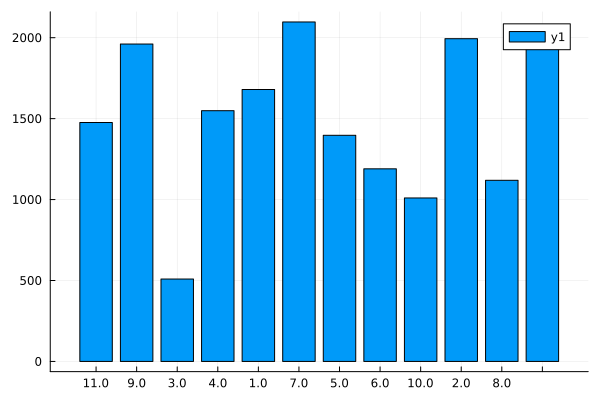

In [5]:
key_fdict,key_farray = pTable(df.key);
bar(key_farray[:,1],key_farray[:,2])

In [6]:

for colname in names(select(df, Not(categorical_columns)))
    noNa_column = skipmissing(df[:,colname])
    (sup_outlier,inf_outlier,ext_sup_outlier,ext_inf_outlier) = quartilOutliers(noNa_column)
    println("----",colname,"----")
    
    sup_outliers = findall(x-> x > sup_outlier, noNa_column)
    inf_outliers = findall(x-> x < inf_outlier, noNa_column)
    
    ext_sup_outliers = findall(x-> x > ext_sup_outlier, noNa_column)
    ext_inf_outliers = findall(x-> x < ext_inf_outlier, noNa_column)

    println("Outliers inf (x<",round(inf_outlier; digits=3),"):",length(inf_outliers)-length(ext_inf_outliers)," sup (x>",round(sup_outlier; digits=3),"):",length(sup_outliers)-length(ext_sup_outliers))
    println("Extreme outliers inf (x<",round(ext_inf_outlier; digits=3),"):",length(ext_inf_outliers)," sup (x>",round(ext_sup_outlier; digits=3),"):",length(ext_sup_outliers))

    if ((length(ext_inf_outliers)+length(ext_sup_outliers))>0)
        allowmissing!(df, colname);
        df[ext_sup_outliers,colname] .= missing
        df[ext_inf_outliers,colname] .= missing
    end
end

----Popularity----
Outliers inf (x<-1.5):0 sup (x>90.5):41
Extreme outliers inf (x<-36.0):0 sup (x>125.0):0
----danceability----
Outliers inf (x<0.091):31 sup (x>1.0):0
Extreme outliers inf (x<-0.249):0 sup (x>1.34):0
----energy----
Outliers inf (x<-0.017):0 sup (x>1.386):0
Extreme outliers inf (x<-0.544):0 sup (x>1.913):0
----loudness----
Outliers inf (x<-16.062):634 sup (x>1.335):3
Extreme outliers inf (x<-22.585):181 sup (x>7.858):0
----speechiness----
Outliers inf (x<-0.038):0 sup (x>0.155):803
Extreme outliers inf (x<-0.11):0 sup (x>0.228):1231
----acousticness----
Outliers inf (x<-0.64):0 sup (x>1.079):0
Extreme outliers inf (x<-1.285):0 sup (x>1.723):0
----instrumentalness----
Outliers inf (x<-0.3):0 sup (x>0.5):1020
Extreme outliers inf (x<-0.6):0 sup (x>0.8):1388
----liveness----
Outliers inf (x<-0.143):0 sup (x>0.499):642
Extreme outliers inf (x<-0.384):0 sup (x>0.74):314
----valence----
Outliers inf (x<-0.266):0 sup (x>1.235):0
Extreme outliers inf (x<-0.828):0 sup (x>1.797)

In [7]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0,String
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0,String
3,Popularity,44.5121,1.0,44.0,100.0,428,"Union{Missing, Float64}"
4,danceability,0.543433,0.0596,0.545,0.989,0,Float64
5,energy,0.662777,2.03e-5,0.7,1.0,0,Float64
6,key,,1.0,,9.0,2014,"Union{Missing, String}"
7,loudness,-7.72315,-22.557,-6.981,1.355,181,"Union{Missing, Float64}"
8,mode,,0,,1,0,String
9,speechiness,0.0608453,0.0225,0.045,0.227,1231,"Union{Missing, Float64}"


### Quantity of missing values for each column

In [8]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

Row,variable,nmissing,eltype,mean,std,min,max,prop
,Symbol,Int64,Type,Union…,Union…,Any,Any,Float64
1,Popularity,428,"Union{Missing, Float64}",44.5121,17.4269,1.0,100.0,4.23469
2,key,2014,"Union{Missing, String}",,,1.0,9.0,19.9268
3,loudness,181,"Union{Missing, Float64}",-7.72315,3.59986,-22.557,1.355,1.79084
4,speechiness,1231,"Union{Missing, Float64}",0.0608453,0.0403151,0.0225,0.227,12.1797
5,instrumentalness,5765,"Union{Missing, Float64}",0.0974663,0.199419,1.0e-6,0.799,57.0397
6,liveness,314,"Union{Missing, Float64}",0.184099,0.131646,0.0119,0.739,3.10676
7,duration_in min/ms,174,"Union{Missing, Float64}",1.96123e5,1.00199e5,0.50165,510587.0,1.72158


In [9]:
map(x -> string(x),mvalues[:,"variable"])

7-element Vector{String}:
 "Popularity"
 "key"
 "loudness"
 "speechiness"
 "instrumentalness"
 "liveness"
 "duration_in min/ms"

### Missing values Imputation

#### Correlation analysis

In [10]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])

deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

6-element Vector{String}:
 "Popularity"
 "loudness"
 "speechiness"
 "instrumentalness"
 "liveness"
 "duration_in min/ms"

In [11]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])

deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))

table_names = append!(["col_name"],na_numeric_columns)

corr_matrix = DataFrame([ name =>[] for name in table_names])
for i in 1:size(df_numerical_columns,2)
    push!(corr_matrix,zeros(length(table_names)))
end

for (index,column) in enumerate(names(df_numerical_columns))
    corr_matrix[index,"col_name"] = column
    for sub_column in na_numeric_columns
        corr_value = cor(df_numerical_columns[:,sub_column],df_numerical_columns[:,column])
        if (abs(corr_value)>0.5)
            corr_matrix[index,sub_column] = corr_value
        end
    end
end

corr_matrix

Row,col_name,Popularity,loudness,speechiness,instrumentalness,liveness,duration_in min/ms
,Any,Any,Any,Any,Any,Any,Any
1,Popularity,1.0,0.0,0.0,0.0,0.0,0.0
2,danceability,0.0,0.0,0.0,0.0,0.0,0.0
3,energy,0.0,0.760718,0.0,0.0,0.0,0.0
4,loudness,0.0,1.0,0.0,0.0,0.0,0.0
5,speechiness,0.0,0.0,1.0,0.0,0.0,0.0
6,acousticness,0.0,-0.577811,0.0,0.0,0.0,0.0
7,instrumentalness,0.0,0.0,0.0,1.0,0.0,0.0
8,liveness,0.0,0.0,0.0,0.0,1.0,0.0
9,valence,0.0,0.0,0.0,0.0,0.0,0.0


As we see, the correlation matrix shows only two values greater than abs(0.5). We can use `energy` or `acousticness` or both to predict `loudness` using a linear regression. It is easy to know that the $R^2$ of the simple model of `energy` is going to be $$R^2=(r)^2=(0.7607)^2 \approx 0.579 \approx 58\%$$ 

Secondly we can try to train a linear regression with `energy` and `acousticness`:

In [12]:
# Linear Regresion

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
lmodel = lm(@formula(loudness  ~ energy+acousticness), df_numerical_columns)

print("R squared: ",r2(lmodel))

R squared: 0.5801087067588673

In [13]:
# Linear Regresion

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
simple_model = lm(@formula(loudness  ~ energy), df_numerical_columns)

print("R squared: ",r2(simple_model))

R squared: 0.5786915469897806

With these results we can consider the simple model to replace the missing values of `loudness`

In [14]:
scatter(df[:,"energy"],df[:,"loudness"], title = "Scatter Plot Life Expectancy vs Adult Mortality Rate", ylabel = "Life Expectancy", xlabel = "Adult Mortality Rate",legend = false)

In [15]:
# Linear Regresion 

loudness = @select(df_numerical_columns, :loudness);
energy = @select(df_numerical_columns, :energy);
energy2 = @select(df_numerical_columns, :energy2 = :energy.^2);
energy3 = @select(df_numerical_columns, :energy3 = :energy.^3);

df_polyreg = hcat(loudness,energy,energy2,energy3)

poly_model = lm(@formula(loudness  ~ energy+energy2+energy3), df_polyreg)

println("R squared: ",r2(poly_model))
println(poly_model)


R squared: 0.6001196443204693
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

loudness ~ 1 + energy + energy2 + energy3

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -20.8171    0.245776  -84.70    <1e-99   -21.2989   -20.3354
energy        41.27      1.52081    27.14    <1e-99    38.2889    44.2511
energy2      -48.2937    2.85503   -16.92    <1e-62   -53.8901   -42.6972
energy3       23.8144    1.634      14.57    <1e-46    20.6114    27.0173
─────────────────────────────────────────────────────────────────────────


In [16]:
for (index,row) in enumerate(completecases(df))
    if (row==false)
        df[index,"loudness"] = predLoudness(df[index,"energy"])
    end
end

In [17]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0,String
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0,String
3,Popularity,44.5121,1.0,44.0,100.0,428,"Union{Missing, Float64}"
4,danceability,0.543433,0.0596,0.545,0.989,0,Float64
5,energy,0.662777,2.03e-5,0.7,1.0,0,Float64
6,key,,1.0,,9.0,2014,"Union{Missing, String}"
7,loudness,-8.00263,-22.557,-7.392,1.342,0,"Union{Missing, Float64}"
8,mode,,0,,1,0,String
9,speechiness,0.0608453,0.0225,0.045,0.227,1231,"Union{Missing, Float64}"


In [18]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

Row,variable,nmissing,eltype,mean,std,min,max,prop
,Symbol,Int64,Type,Union…,Union…,Any,Any,Float64
1,Popularity,428,"Union{Missing, Float64}",44.5121,17.4269,1.0,100.0,4.31191
2,key,2014,"Union{Missing, String}",,,1.0,9.0,20.2901
3,speechiness,1231,"Union{Missing, Float64}",0.0608453,0.0403151,0.0225,0.227,12.4018
4,instrumentalness,5765,"Union{Missing, Float64}",0.0974663,0.199419,1.0e-6,0.799,58.0798
5,liveness,314,"Union{Missing, Float64}",0.184099,0.131646,0.0119,0.739,3.16341
6,duration_in min/ms,174,"Union{Missing, Float64}",1.96123e5,1.00199e5,0.50165,510587.0,1.75297


In [19]:
using ScikitLearn
#@sk_import neighbors: KNeighborsClassifier
@sk_import neighbors: KNeighborsRegressor
@sk_import tree:DecisionTreeClassifier
using ScikitLearn.CrossValidation: cross_val_score

In [20]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])
deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
X = select(df_numerical_columns,Not(na_numeric_columns))

predictor_df = select(df,names(X))

for colname in na_numeric_columns
    y = select(df_numerical_columns,colname)
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(Matrix(X), Matrix(y))
    for (index,row) in enumerate(completecases(df))
        if (row==false)
            v = collect(predictor_df[index,:])
            v_matrix = permutedims(reshape(v, length(v), 1))
            df[index,colname] = model.predict(v_matrix)[1]
        end
    end
end

In [21]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

Row,variable,nmissing,eltype,mean,std,min,max,prop
,Symbol,Int64,Type,Union…,Union…,Any,Any,Float64
1,key,2014,"Union{Missing, String}",,,1.0,9.0,100.0


In [22]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0,String
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0,String
3,Popularity,43.5496,1.0,43.0,98.0,0,"Union{Missing, Float64}"
4,danceability,0.543433,0.0596,0.545,0.989,0,Float64
5,energy,0.662777,2.03e-5,0.7,1.0,0,Float64
6,key,,1.0,,9.0,2014,"Union{Missing, String}"
7,loudness,-8.00263,-22.557,-7.392,1.342,0,"Union{Missing, Float64}"
8,mode,,0,,1,0,String
9,speechiness,0.0589988,0.0225,0.0491,0.227,0,"Union{Missing, Float64}"


In [23]:
nona_df = df[completecases(df),:]

X = select(nona_df,Not(["key","Class","Artist Name","Track Name"]))
y = nona_df.key

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(Matrix(X), reshape(y, 15982, 1))

predictor_df = select(df,names(X))

for (index,row) in enumerate(completecases(df))
    if (row==false)
        v = collect(predictor_df[index,:])
        v_matrix = permutedims(reshape(v, length(v), 1))
        df[index,"key"] = tree.predict(v_matrix)[1]
    end
end

In [24]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0,String
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0,String
3,Popularity,43.5496,1.0,43.0,98.0,0,"Union{Missing, Float64}"
4,danceability,0.543433,0.0596,0.545,0.989,0,Float64
5,energy,0.662777,2.03e-5,0.7,1.0,0,Float64
6,key,,1.0,,9.0,0,"Union{Missing, String}"
7,loudness,-8.00263,-22.557,-7.392,1.342,0,"Union{Missing, Float64}"
8,mode,,0,,1,0,String
9,speechiness,0.0589988,0.0225,0.0491,0.227,0,"Union{Missing, Float64}"


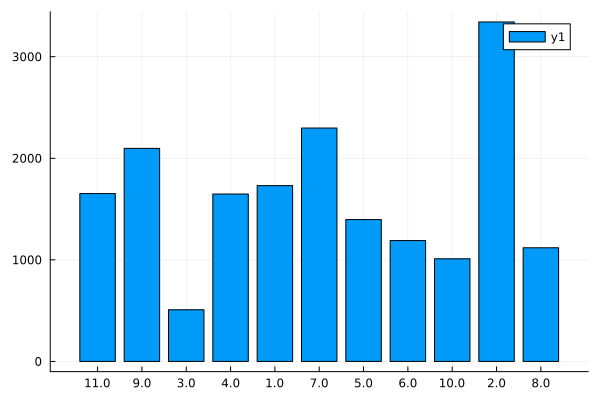

In [25]:
key_fdict,key_farray = pTable(df.key);
bar(key_farray[:,1],key_farray[:,2])

In [26]:
durationToSeconds(df."duration_in min/ms")
rename!(df,"duration_in min/ms" => "duration_seconds")

Row,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seconds,time_signature,Class
,String,String,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64?,String,String
1,Bruno Mars,That's What I Like (feat. Gucci Mane),52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171,0.00965882,0.0849,0.899,134.071,234.596,4,5
2,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011,0.00401,0.101,0.569,116.454,251.733,4,10
3,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486,0.000196,0.394,0.787,147.681,109.667,4,6
4,Deno,Lingo (feat. J.I & Chunkz),39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212,0.0117566,0.122,0.569,107.033,173.968,4,5
5,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169,0.0161,0.172,0.0918,199.06,229.96,4,10
6,The Stooges,Search and Destroy - Iggy Pop Mix,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353,0.00604,0.172,0.241,152.952,208.133,4,6
7,Solomon Burke,None Of Us Are Free,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404,1.34e-6,0.0981,0.677,143.292,329.387,4,2
8,Randy Travis,On the Other Hand,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175,5.65e-6,0.132,0.347,96.03,186.347,4,4
9,Professional Murder Music,Slow,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5,0.0013,0.179,0.318,120.857,237.867,4,8


### Duplicate rows

In [27]:
clean_df = copy(unique(df))

Row,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seconds,time_signature,Class
,String,String,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64?,String,String
1,Bruno Mars,That's What I Like (feat. Gucci Mane),52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171,0.00965882,0.0849,0.899,134.071,234.596,4,5
2,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011,0.00401,0.101,0.569,116.454,251.733,4,10
3,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486,0.000196,0.394,0.787,147.681,109.667,4,6
4,Deno,Lingo (feat. J.I & Chunkz),39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212,0.0117566,0.122,0.569,107.033,173.968,4,5
5,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169,0.0161,0.172,0.0918,199.06,229.96,4,10
6,The Stooges,Search and Destroy - Iggy Pop Mix,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353,0.00604,0.172,0.241,152.952,208.133,4,6
7,Solomon Burke,None Of Us Are Free,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404,1.34e-6,0.0981,0.677,143.292,329.387,4,2
8,Randy Travis,On the Other Hand,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175,5.65e-6,0.132,0.347,96.03,186.347,4,4
9,Professional Murder Music,Slow,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5,0.0013,0.179,0.318,120.857,237.867,4,8


In [28]:
CSV.write("./dataset/clean_music_genre.csv",clean_df)

"./dataset/clean_music_genre.csv"